Auteur : David Paulino
# Expected Goals
Ce Jupyter Notebook a pour but d'être un support pour la rédaction du Travail de Bachelor nommé "Analyse et optimisation de l'expected goal : application au machine learning" 

Assurez-vous d'avoir installé les librairies suivantes :
- numpy
- pandas
- matplotlib
- mplsoccer

In [19]:
# Import des libs
import pandas as pd
import numpy as np
import json
# Plotting
import matplotlib.pyplot as plt
# Permet de plot des terrains de football
from mplsoccer import VerticalPitch, Pitch, Standardizer
# Nécessaire à l'import des datasets
import os
import pathlib

# Permet d'éviter les warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Données
La première partie de notebook vise à importer, visualiser et observer les caractéristiques de chacun des attributs du dataset. Cela va permettre de mieux comprendre le dataset dans son ensemble, d'observer d'éventuelles données manquantes et de pouvoir prédire à l'avance d'éventuels comportements.

In [20]:
# Chargement des données
train = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'events')

# Permet de récupérer tous les fichiers dans le dossier /TB/events
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
for file_name in onlyfiles:
    path_to_file = mypath + "/" + file_name
    
    with open(path_to_file) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

Maintenant, nous allons filtrer uniquement par les données qui nous intéressent, à savoir les tirs.
On utilise "subEventName" pour retirer les penaltys.

In [21]:
shots = train[train["subEventName"] == "Shot"]

# Visualisation
## Position des tirs

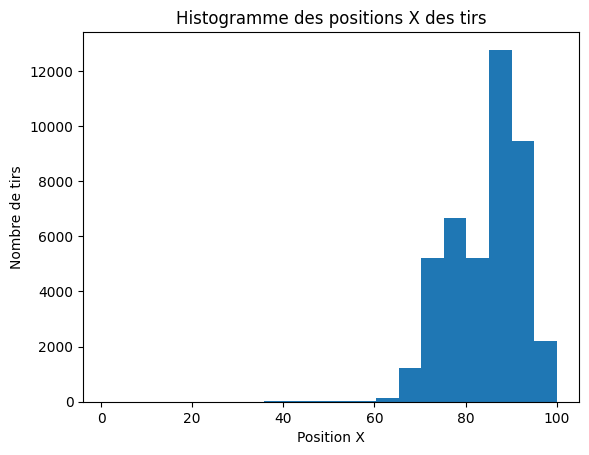

In [22]:
# Histogramme des positions X des tirs
# X représente la longueur du terrain malgré le fait que le terrain soit en 100x100

x_pos = shots["positions"].apply(lambda x: x[0]["x"])
plt.hist(x_pos, bins=20)
plt.title("Histogramme des positions X des tirs")
plt.xlabel("Position X")
plt.ylabel("Nombre de tirs")
plt.show()

On peut voir que tous les tirs sont effectuées dans la partie haute du terrain. Cependant, il est important de noter que les tirs ont été normalisés par rapport au sens du but. Ainsi, tous les tirs effectués dans le but adverse sont considérés comme des tirs dans la partie haute du terrain. On peut notamment le voir dans le graphique qui suit.

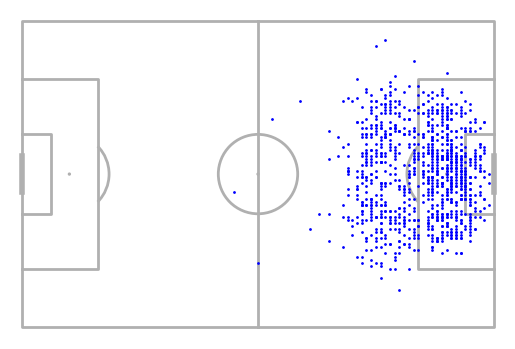

In [23]:
# Affichage des 1000 premibers tirs sur un terrain
# On peut voir qu'ils sont tous dans une seule moitié de terrain alors qu'un match se joue dans les deux sens
# Les données utilisées viennent de Wyscout

pitch = Pitch(pitch_type='wyscout')

fig, ax = pitch.draw(constrained_layout=True, tight_layout=False)

pitch.scatter(x_pos[:1000], shots["positions"].apply(lambda x: x[0]["y"])[:1000], ax=ax, s=1, color='blue')

# Transformation des données
Le but de la transformation de données est de convertir les positions X et Y en mètres. Suite à cela, nous allons pouvoir calculer la distance entre le tireur et le but adverse. Ensuite, nous allons également calculer l'angle de tir. Ces deux nouvelles caractéristiques vont nous permettre d'établir correctement un modèle d'expected goals.

In [34]:
# Taille du terrain
pitch_size = (105, 68)
# On transforme d'abord les positions des tirs correctements
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * pitch_size[0]/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * pitch_size[1]/100)
# Utile pour le calcul de la distance au but et de l'angle de tir
# L'attribut C est un équivalent de Y mais il permet de situer le but en position 0, 0
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * pitch_size[1]/100)
#print(shots[["X", "Y", "C"]].head())

         X      Y      C
213   6.30  38.76   4.76
302  17.85  28.56   5.44
498   4.20  29.24   4.76
577  16.80  14.28  19.72
629  28.35  34.68   0.68


In [45]:
# Les coordonnées du but sont (0, 50). On peut le voir sur le glossaire de Wyscout dans "Pitch Coordinates"
# Cependant, on a besoin de les transformer pour qu'elles soient dans le même format que les positions des tirs
# Pour rappel, la taille du terrain est de 105x68
# On choisit également le but en 0, 50 car cela nous permettra de calculer l'angle du tir par rapport au but
goal_coordinates = np.array([0*pitch_size[0]/100, 50*pitch_size[1]/100])
print(goal_coordinates)

# Largeur du but
goal_width = 7.32
# On calcule la distance entre le but et le tir avec la dimension 105x68
shots["distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                          np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                          # On ajoute pi pour avoir l'angle par rapport au but et le faire basculer dans le bon quadrant
                          np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

# Print la distance, le X et le Y des 10 premiers tirs
shots[["distance", "X", "Y", "angle", "positions"]].describe()


[ 0. 34.]


,distance,X,Y,angle
count,43078.000000,43078.000000,43078.000000,43078.000000
mean,18.592949,15.992062,33.473875,0.414428
std,8.419041,8.534094,9.366242,0.254495
min,0.680000,0.000000,0.000000,0.040088
25%,12.249445,9.450000,26.520000,0.250988
50%,17.153297,13.650000,33.320000,0.327782
75%,24.936000,23.100000,40.800000,0.505984
max,103.952224,103.950000,68.000000,3.141593
